In [61]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
def smooth(x, window_len=11, window="hanning"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [63]:
# rel_path = "Labs/lab_11122019/"
# rel_path = "Labs/muon_271119/Run1/"
# rel_path = "Labs/lab_11122019/"
rel_path = "Labs/muon_191219/"
df = pd.read_csv(rel_path + 'ch1_test.csv', header=None)
with open(rel_path+"event_information.log", "r") as f:
        info = f.readlines()
        n_events = int(info[0].split()[-1])
        n_per_event = int(info[1].split()[-1])

In [64]:
timesteps = np.arange(0,n_per_event,1)

In [65]:
raw_data = df.values[7].flatten()
raw_data *= -1.0
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((smoothed_data[24 : n_per_event + 24 ,np.newaxis], timesteps[:,np.newaxis]), axis=1)
peaks, properties = signal.find_peaks(data[: ,0], height=0.2 * data[: ,0].max())
results_w = signal.peak_widths(data[: ,0], peaks, rel_height=0.95)

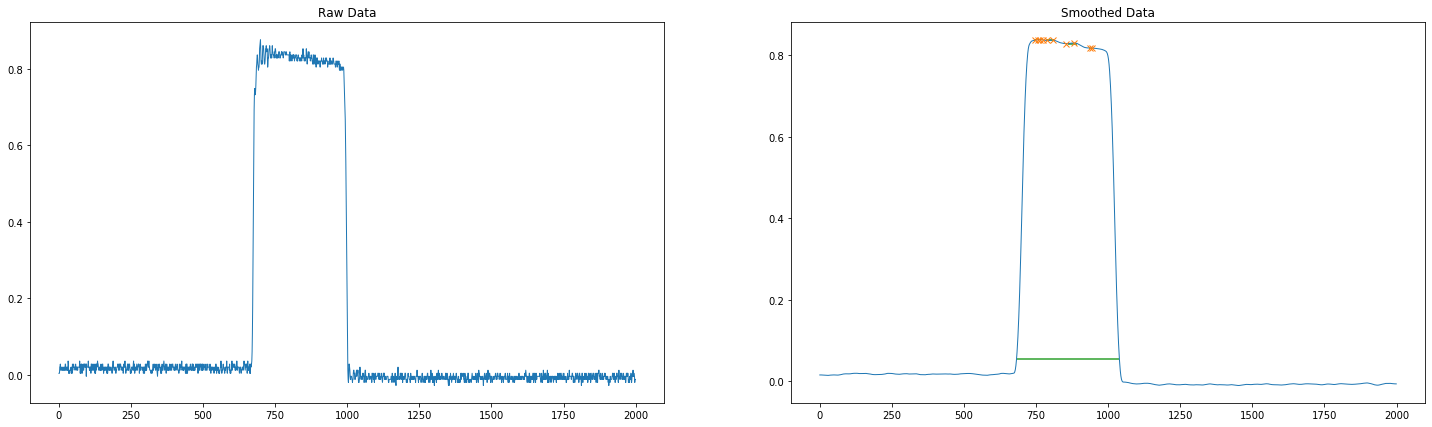

In [66]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.plot(peaks, data[:,0][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [67]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size-1):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,0]}")

Peaks width: [  6.11111111   4.49393939 356.52097722   2.52         5.66666667
  20.78833333   2.9         31.26         6.45         2.85      ]
Found peak in range: 743.2888888888895, 749.3999999999957
Found peak in range: 755.3227272727263, 759.8166666666677
Found peak in range: 682.2998561151079, 1038.8208333333334
Found peak in range: 773.0499999999998, 775.5699999999988
Found peak in range: 786.0833333333328, 791.7500000000022
Found peak in range: 792.775000000001, 813.5633333333335
Found peak in range: 854.0499999999996, 856.9499999999922
Found peak in range: 861.8000000000009, 893.06
Found peak in range: 932.1999999999982, 938.6500000000001
Found peaks at indices [745 757 765 774 788 807 855 882 936 943] with amplitude: [0.8376512 0.838752  0.8388416 0.8382144 0.8369216 0.8377408 0.8289472
 0.830496  0.8183616 0.8182208]


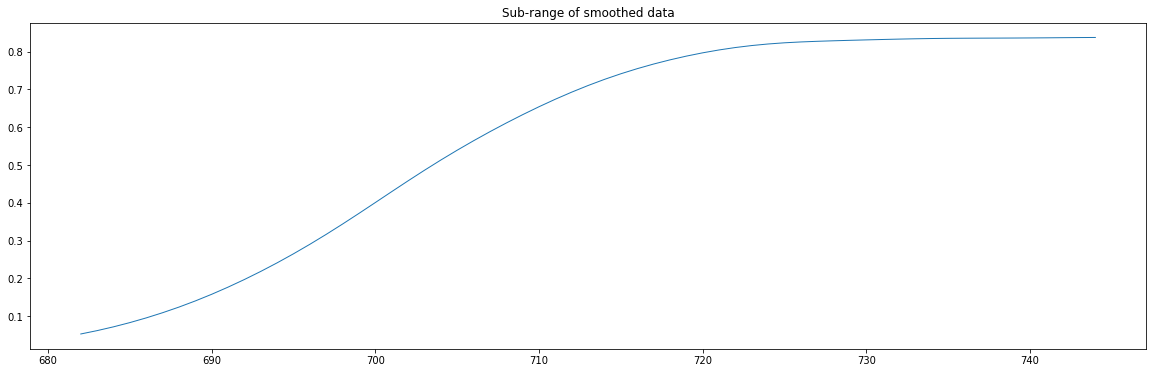

In [68]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

In [69]:
import iminuit
import probfit

In [70]:
# We want to speed things up with Cython
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [71]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [72]:
iminuit.describe(sigmoid)

['x', 'p0', 'p1', 'p2', 'p3']

In [73]:
from scipy.interpolate import interp1d
f1 = interp1d(
                data[a : peaks[0] + 1, 1],
                data[a : peaks[0] + 1, 0],
            )
xx = np.linspace(data[a, 1], data[peaks[0], 1], num=200)
chi2_fit = probfit.Chi2Regression(sigmoid, xx, f1(xx))

In [74]:
chi2_fit = probfit.Chi2Regression(sigmoid, xx, f1(xx))
            # chi2_fit = probfit.Chi2Regression(
            #     sigmoid, timesteps[a : peaks[0]], smoothed_data[a : peaks[0]]
            # )
            # chi2_fit = probfit.Chi2Regression(
            #     sigmoid,
            #     data[a : peaks[0], 1],
            #     data[a : peaks[0], 0],
            # )

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0] + 1, 0]),
                p1=peaks[0],
                p3=np.min(data[a : peaks[0] + 1, 0]),
                limit_p3=(0.001, 1.0),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))

------------------------------------------------------------------
| FCN = 0.003658                |     Ncalls=383 (383 total)     |
| EDM = 5.2E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

In [75]:
iminuit.describe(unbinned_LH)

['p0', 'p1', 'p2', 'p3']

In [76]:
minuit.migrad()

------------------------------------------------------------------
| FCN = 0.003606                |     Ncalls=28 (451 total)      |
| EDM = 3.54E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 0.003606                |     Ncalls=28 (451 total)      |
| EDM = 3.54E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.84    |   0.15    |            |            |         |         |       |
| 1 | p1   |    701    |     6     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.09    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.629   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

In [77]:
minuit.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.84    |   0.17    |            |            |         |         |       |
| 1 | p1   |    701    |     6     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.10    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.519   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------
--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.26 -0.59 -0.60 |
| p1 |  0.26  1.00 -0.20  0.32 |
| p2 | -0.59 -0.20  1.00  0.26 |
| p3 | -0.60  0.32  0.26  1.00 |
--------------------------------


------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.84    |   0.17    |            |            |         |         |       |
| 1 | p1   |    701    |     6     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.10    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.519   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

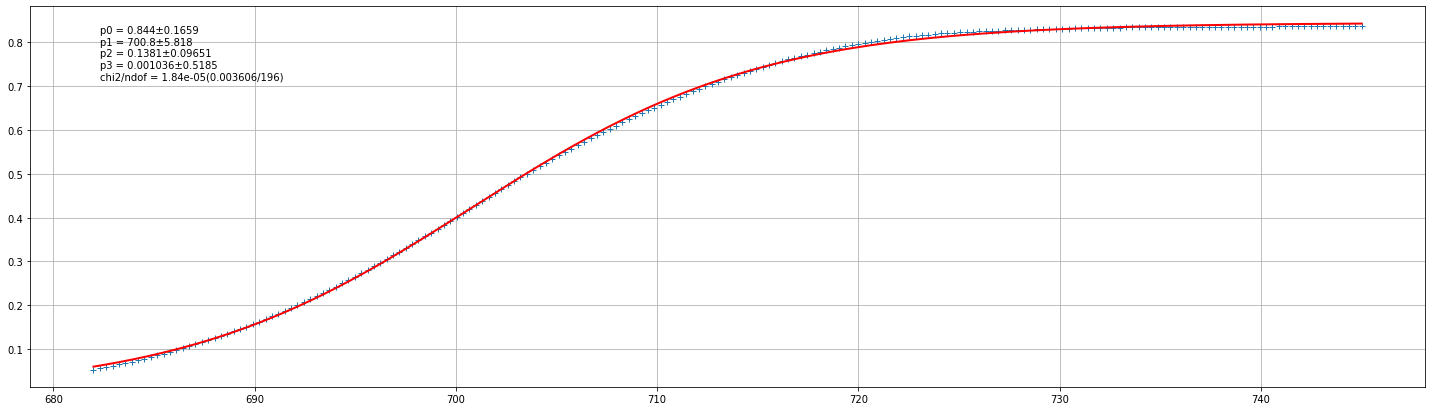

In [87]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [79]:
minuit.print_fmin()
minuit.print_matrix()

------------------------------------------------------------------
| FCN = 0.003606                |     Ncalls=28 (493 total)      |
| EDM = 3.54E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.26 -0.59 -0.60 |
| p1 |  0.26  1.00 -0.20  0.32 |
| p2 | -0.59 -0.20  1.00  0.26 

In [80]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 55e2dd4b6860>
  p0: 0.8439923372488921
  p1: 700.8074080694828
  p2: 0.13812720960032598
  p3: 0.0010357634792571063
<ErrorView of Minuit at 55e2dd4b6860>
  p0: 0.16587798516207836
  p1: 5.8184800751098305
  p2: 0.09650903207201034
  p3: 0.5185277167453127


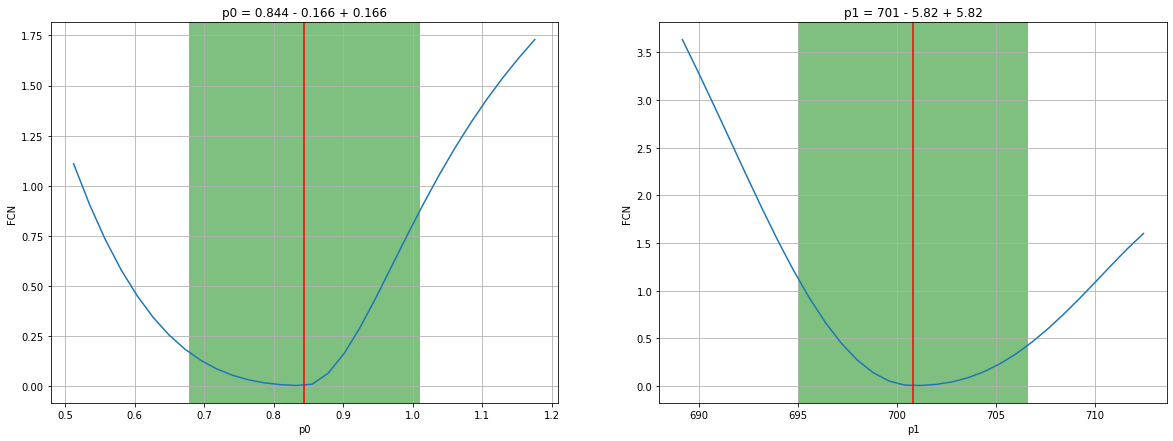

In [81]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=0.537444
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=0.608965
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=0.680486
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=0.752007
  """


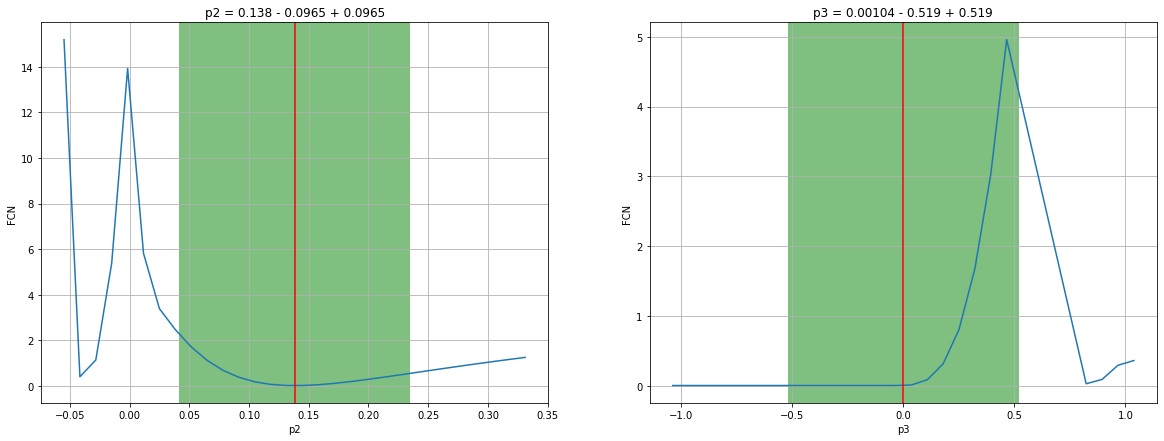

In [82]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()